# 基本时序预测模型

In [1]:
# 都有的包，直接导入
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, LSTM, GRU
from tensorflow.python.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, r2_score
import matplotlib
matplotlib.rc("font",family='MicroSoft YaHei',weight="bold")


In [2]:
# 图形绘制函数
def all_data(data, title='', xlabel='', ylabel=''):
    plt.plot(data['Date'],data['Pack(10k)'], color='r')
    # plt.title(title)
    plt.xlabel('日期')
    plt.ylabel('快递量（万）')
    plt.grid(True)
    plt.show()

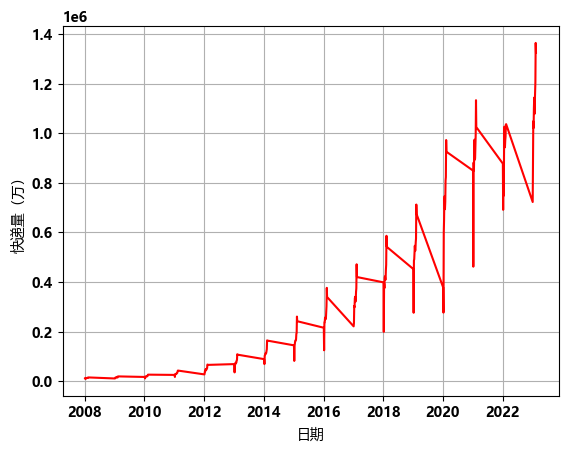

In [3]:
# 处理前数据导入与展示
index0 = pd.read_csv('D:\Codes\Python\pythonProject\\test\\08.01-23.11快递量数据.csv')
data0 = index0.drop(index0.columns[2], axis=1) #数据提取，只要前两行
all_data(data0, title='处理前数据展示效果', xlabel='Data', ylabel='Package')    # 数据展示

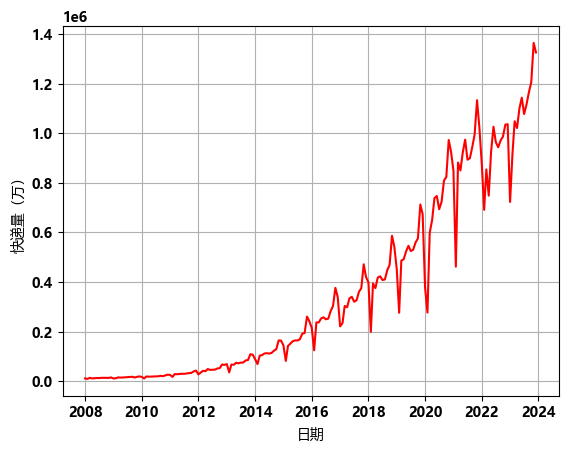

In [4]:
# 处理后数据导入与展示
index = pd.read_csv('D:\Codes\Python\pythonProject\\test/multi_models/pack_data.csv')
data = index
data['Date']=pd.to_datetime(data['Date'],format='%Y-%m ')   #格式转化
all_data(data[:-12], title='处理后数据展示效果', xlabel='Data', ylabel='Package')    # 数据展示
# data = np.array(data)

In [62]:
data[:-12]

,Date,Pack(10k)
0,2008-01-01,11227.7
1,2008-02-01,9137.0
2,2008-03-01,13350.8
3,2008-04-01,11220.4
4,2008-05-01,12187.4
...,...,...
187,2023-08-01,1116156.9
188,2023-09-01,1165679.5
189,2023-10-01,1205526.2
190,2023-11-01,1364293.4


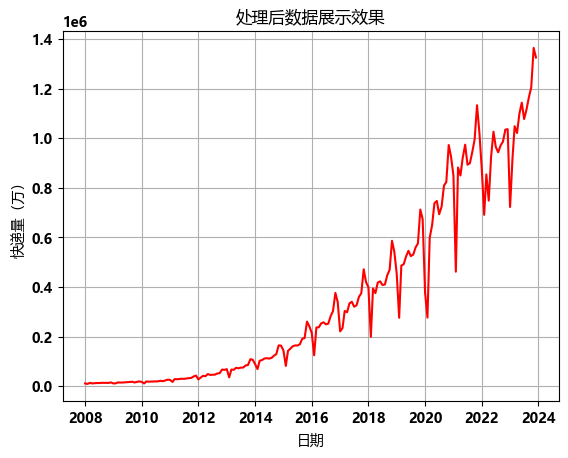

In [63]:
all_data(data[:-12], title='处理后数据展示效果', xlabel='Data', ylabel='Package')    # 数据展示

### 构造SVR初始模型

In [6]:
data = np.array(data)
from sklearn.svm import SVR
#划分训练集和测试集
# 数据初步分组
data_train = data[:144] #训练集,2008年-2019年的数据，共144个
data_train_time = data_train[:,0]   #训练数据时间标签
data_train_pack = data_train[:,1]   #训练数据
data_test = data[144:192]  #测试集,仅有2021年-2023年的数据，共36个
data_test_time = data_test[:,0] #测试数据时间标签
data_test_pack = data_test[:,1] #测试数据

In [7]:
#归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_pack = scaler.fit_transform(data_train_pack.reshape(-1,1))
data_test_pack = scaler.transform(data_test_pack.reshape(-1,1))

In [8]:
# 分离特征和目标
time_step = 1
train_x, test_x = data_train_pack[:,0], data_test_pack[:,0]
time_y = data_test_time[time_step:]
time_x = data_test_time[:-time_step]
# 数据重塑 创建指定时间步长的数据集
def create_dataset(x, time_step):
    xs, ys = [], []
    for i in range(len(x) - time_step):
        v = x[i:(i + time_step)]
        xs.append(v)
        ys.append(x[i + time_step])
    return np.array(xs), np.array(ys)
# 数据重塑
time_step = 1
train_x, train_y = create_dataset(train_x, time_step)
test_x, test_y = create_dataset(test_x, time_step)

In [9]:
# SVR模型需要的输入数据中只需要两个维度{[样本数量],[特征数量]}
train_x = train_x.reshape(train_x.shape[0],1)
test_x = test_x.reshape(test_x.shape[0],1)

In [7]:
train_x.reshape(train_x,1)

TypeError: only integer scalar arrays can be converted to a scalar index

In [10]:
#构建SVR
'''参数说明
1. kernel：核函数，可选值有linear、poly、rbf、sigmoid、precomputed
2. C：惩罚系数，越大拟合度越高，训练效果越好；越小则关注训练集的泛化能力
3. gamma：核函数中rbf核的参数，越大则越平滑，越接近于线性，越可能导致过拟合；
4. epsilon：误差范围，越小则越关注训练集的泛化能力，越接近于线性，越可能导致过拟合；
'''
svr_rbf = SVR(kernel='rbf', C=20, gamma=0.01, epsilon=0.1)
svr_rbf.fit(train_x, train_y)


SVR(C=20, gamma=0.01)

In [11]:
y_pred = svr_rbf.predict(test_x)

In [12]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
y_real = scaler.inverse_transform(test_y.reshape(-1,1))
x_real = scaler.inverse_transform(test_x.reshape(-1,1))

In [13]:
# 绘制预测结果
def get_pred_plt(real_x, real_y, y_pred, time_x, time_y, title='预测结果对比图', xlabel='日期', ylabel='快递量（万）'):
    plt.figure()
    plt.plot(time_y, y_pred, label = '预测结果', linestyle = '--')
    plt.plot(time_y, real_y, label = '真实结果', linestyle = '-')
    # plt.plot(time_x, real_x, color='g', label = 'Real_x')
    # plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(rotation=-15)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

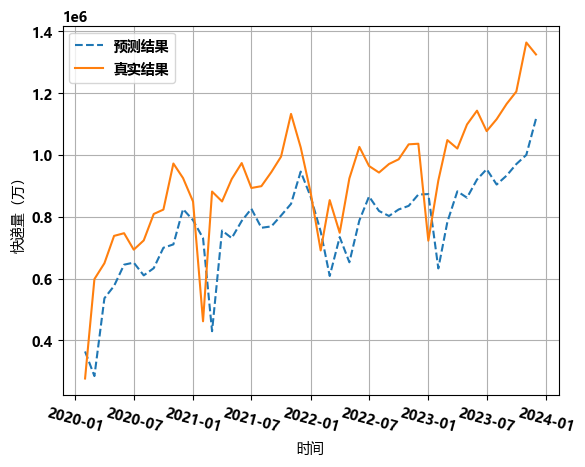

In [14]:
time_x = data_test_time[:-time_step]
time_y = data_test_time[time_step:]
get_pred_plt(x_real, y_real, y_pred, time_x, time_y, title='SVR 模型预测对比图', xlabel='时间', ylabel='快递量（万）')

In [10]:
# 模型误差评估
def get_error(real_y, y_pred):
    mse = np.mean((real_y - y_pred) ** 2)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(mean_squared_log_error(real_y, y_pred))
    mape = np.mean(np.abs((real_y - y_pred) / real_y)) * 100
    r2 = r2_score(real_y, y_pred)
    errs = [mse, rmse, rmsle, mape, r2]
    return errs

In [137]:
err_y = get_error(y_real, y_pred)
err_x = get_error(x_real, y_pred)
err = pd.DataFrame((err_x, err_y), index=['err_x', 'err_y'], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])

In [139]:
err.to_csv('./basic/svr_err.csv', index=True, header=True, encoding='utf-8')

# BP神经网络

In [15]:
#创建BP神经网络
def get_BP_model(time_step):
    # 定义模型结构
    model = Sequential()
    model.add(Dense(10, input_dim=time_step, activation='relu'))  # 输入层，输入维度数为时间步长
    model.add(Dense(10, activation='relu'))  # 隐藏层
    model.add(Dense(1))  # 输出层
    # 编译模型
    model.compile(loss='mean_squared_error', optimizer='SGD')
    return model

In [16]:
# 数据重塑
time_step = 2
train_x, test_x = data_train_pack[:,0], data_test_pack[:,0]
train_x, train_y = create_dataset(train_x, time_step)
test_x, test_y = create_dataset(test_x, time_step)


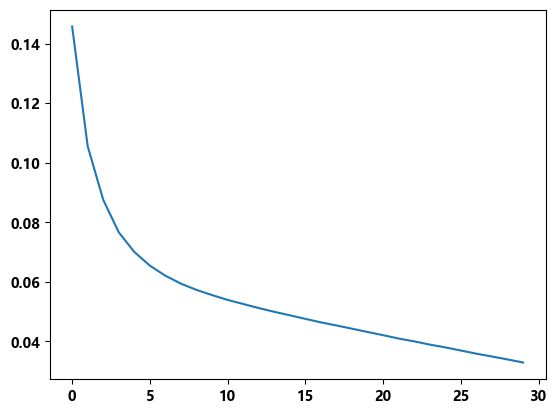

In [20]:
BP_model = get_BP_model(time_step)
history = BP_model.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
plt.plot(history.history['loss'])
# plt.title('BP神经网络模型损失函数图像')
plt.show()

In [18]:
bp_pred = BP_model.predict(test_x)
bp_pred = scaler.inverse_transform(bp_pred.reshape(-1,1))
bp_real_y = scaler.inverse_transform(test_y.reshape(-1,1))
bp_real_x = scaler.inverse_transform(test_x[:,0].reshape(-1,1))

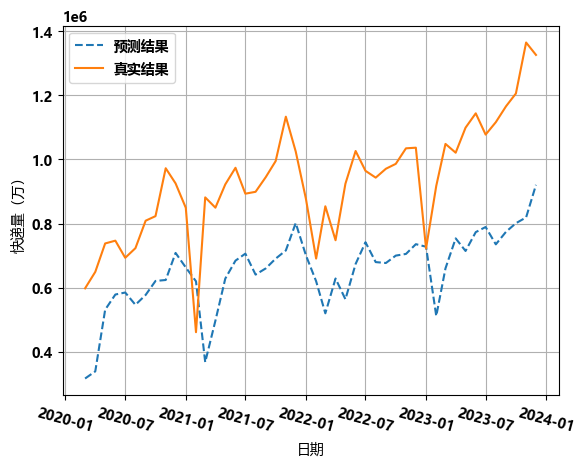

In [19]:
time_x = data_test_time[:-time_step]
time_y = data_test_time[time_step:]
get_pred_plt(bp_real_x, bp_real_y, bp_pred, time_x, time_y, title='BP 神经网络模型预测结果对比图', xlabel='日期', ylabel='快递量（万）')

In [177]:
bp_err_x = get_error(bp_real_x, bp_pred)
bp_err_y = get_error(bp_real_y, bp_pred)
err = pd.DataFrame((bp_err_x, bp_err_y), index=['err_x', 'err_y'], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])


In [184]:
# 对神经网络模型重复建模实验
bp_preds = []
for i in range(10):
    model = get_BP_model(time_step)
    model.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
    bp_pred = model.predict(test_x)
    bp_pred = scaler.inverse_transform(bp_pred.reshape(-1,1))
    bp_preds.append(bp_pred)


In [216]:
bp_errs_x, bp_errs_y = [], []
for i in range(10):
    bp_err_x = get_error(bp_real_x, bp_preds[i])
    bp_err_y = get_error(bp_real_y, bp_preds[i])
    bp_errs_x.append(bp_err_x)
    bp_errs_y.append(bp_err_y)
bp_errs_xs = pd.DataFrame(bp_errs_x, index=['bp_model_'+str(i) for i in range(1,11)], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])
bp_errs_ys = pd.DataFrame(bp_errs_y, index=['bp_model_'+str(i) for i in range(1,11)], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])
mean = bp_errs_xs.mean(axis=0)
mean = pd.DataFrame(mean).T
mean.index = ['Average']
bp_errs_xs = pd.concat([bp_errs_xs, mean], axis=0)

In [214]:
pd.DataFrame(mean).T

,MSE,RMSE,RMSLE,MAPE,R2
0,1.379957e+11,307690.138883,0.484095,32.012216,-2.558815


In [217]:
bp_errs_xs.to_csv('./basic/bp_errs_x.csv', index=True, header=True, encoding='utf-8')
bp_errs_ys.to_csv('./basic/bp_errs_y.csv', index=True, header=True, encoding='utf-8')

# RNN神经网络

In [21]:
# 创建RNN神经网络
from keras.layers import SimpleRNN
def get_RNN_model(time_step):
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=(time_step, 1), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='SGD')
    return model

In [22]:
# 数据重塑，输入RNN模型的数据中需要两个维度{[样本数量],[时间步长],[特征数量]}
train_x = train_x.reshape(train_x.shape[0], time_step, 1)
test_x = test_x.reshape(test_x.shape[0], time_step, 1)

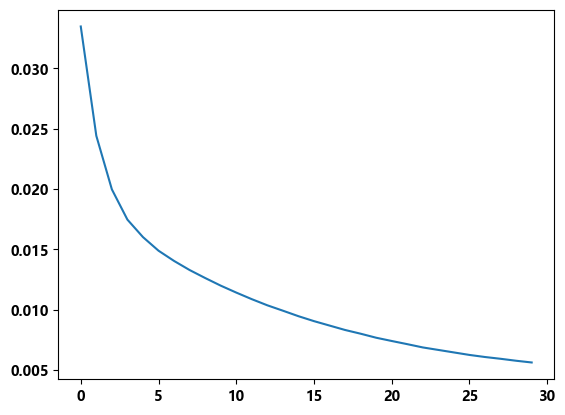

In [26]:
rnn_model = get_RNN_model(time_step)
history = rnn_model.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
plt.plot(history.history['loss'])
# plt.title('RNN模型损失函数图像')
plt.show()

In [24]:
# 模型预测
rnn_pred = rnn_model.predict(test_x)
rnn_pred = scaler.inverse_transform(rnn_pred.reshape(-1,1))
rnn_real_y = scaler.inverse_transform(test_y.reshape(-1,1))
rnn_real_x = scaler.inverse_transform(test_x[:,0].reshape(-1,1))

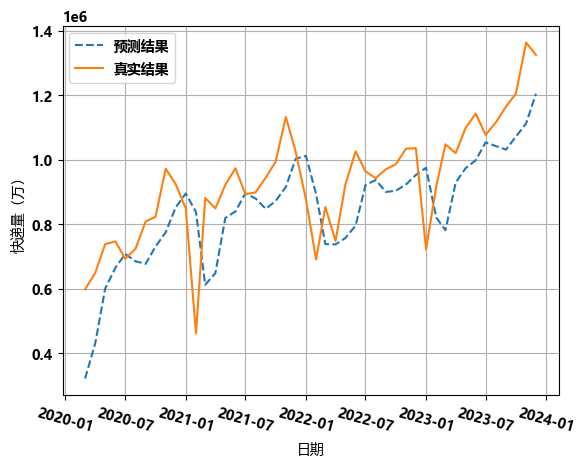

In [25]:
get_pred_plt(rnn_real_x, rnn_real_y, rnn_pred, time_x, time_y, title='RNN 模型预测结果对比图', xlabel='日期', ylabel='快递量（万）')

In [199]:
# 模型误差评估
rnn_err_x = get_error(rnn_real_x, rnn_pred)
rnn_err_y = get_error(rnn_real_y, rnn_pred)
err = pd.DataFrame((rnn_err_x, rnn_err_y), index=['rnn_err_x', 'rnn_err_y'], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])

In [222]:
# 对神经网络模型重复建模实验
# 获取预测结果
rnn_preds = []
for i in range(10):
    model = get_RNN_model(time_step)
    model.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
    rnn_pred = model.predict(test_x)
    rnn_pred = scaler.inverse_transform(rnn_pred.reshape(-1,1))
    rnn_preds.append(rnn_pred)
# 生成误差评价
rnn_errs_x, rnn_errs_y = [], []
for i in range(10):
    rnn_err_x = get_error(rnn_real_x, rnn_preds[i])
    rnn_err_y = get_error(rnn_real_y, rnn_preds[i])
    rnn_errs_x.append(rnn_err_x)
    rnn_errs_y.append(rnn_err_y)
rnn_errs_xs = pd.DataFrame(rnn_errs_x, index=['rnn_model_'+str(i) for i in range(1,11)], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])
rnn_errs_ys = pd.DataFrame(rnn_errs_y, index=['rnn_model_'+str(i) for i in range(1,11)], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])
mean = rnn_errs_xs.mean(axis=0)
mean = pd.DataFrame(mean).T
mean.index = ['Average']
rnn_errs_xs = pd.concat([rnn_errs_xs, mean], axis=0)

In [223]:
#关于y的误差结果越来越差，后面对比只保存x的了
rnn_errs_xs.to_csv('./basic/rnn_errs_x.csv', index=True, header=True, encoding='utf-8')

# LSTM模型

In [27]:
# 创建LSTM模型
def get_lstm_model(time_step, learning_rate):
    opt = optimizers.adagrad_v2.Adagrad(learning_rate=learning_rate)
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_step, 1), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [28]:
# 数据重塑，输入RNN模型的数据中需要两个维度{[样本数量],[时间步长],[特征数量]}
train_x, test_x = data_train_pack[:,0], data_test_pack[:,0]
time_y = data_test_time[time_step:]
time_x = data_test_time[:-time_step]
train_x, train_y = create_dataset(train_x, time_step)
test_x, test_y = create_dataset(test_x, time_step)
train_x = train_x.reshape(train_x.shape[0], time_step, 1)
test_x = test_x.reshape(test_x.shape[0], time_step, 1)

In [29]:
# 模型训练
lstm_model1 = get_lstm_model(time_step, 0.01)
history1 = lstm_model1.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
lstm_model2 = get_lstm_model(time_step, 0.05)
history2 = lstm_model2.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)

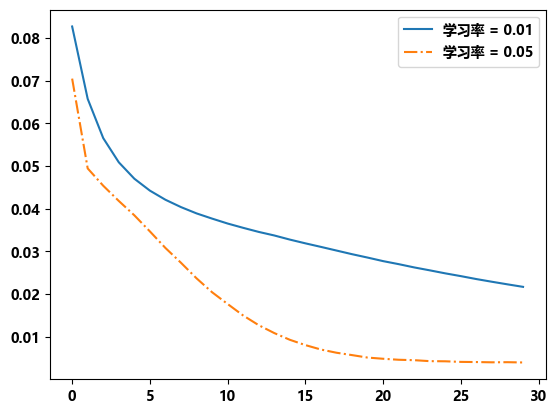

In [33]:
plt.plot(history1.history['loss'], label='学习率 = 0.01')
plt.plot(history2.history['loss'], label='学习率 = 0.05', linestyle = '-.')
# plt.title('LSTM模型损失函数图像')
plt.legend()
plt.show()

In [31]:
# 绘制预测结果
def get_pred_plt(real_x, real_y, y_pred, time_x, time_y, title='Predict', xlabel='Data', ylabel='Package'):
    plt.figure()
    plt.plot(time_y, y_pred[0], linestyle='--', label = '学习率 = 0.01')
    plt.plot(time_y, y_pred[1], linestyle='-.', label = '学习率 = 0.05')
    plt.plot(time_y, real_y, linestyle='-', label = '真实结果')
    # plt.plot(time_x, real_x, color='g', label = 'Real_x')
    # plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(rotation=-15)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

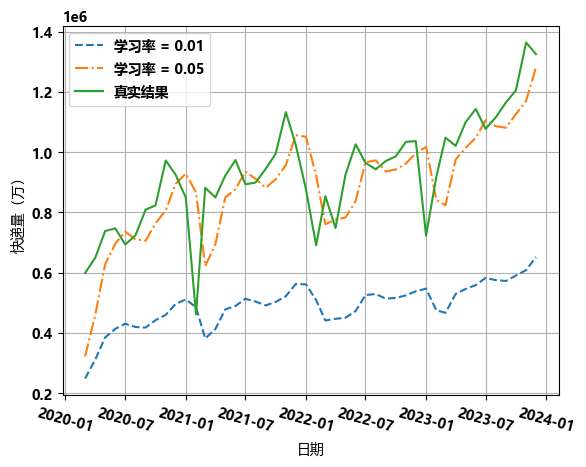

In [32]:
# 模型预测
lstm_pred = []
lstm_pred1 = lstm_model1.predict(test_x)
lstm_pred2 = lstm_model2.predict(test_x)
lstm_pred.append(scaler.inverse_transform(lstm_pred1.reshape(-1,1)))
lstm_pred.append(scaler.inverse_transform(lstm_pred2.reshape(-1,1)))
lstm_real_y = scaler.inverse_transform(test_y.reshape(-1,1))
lstm_real_x = scaler.inverse_transform(test_x[:,0].reshape(-1,1))
get_pred_plt(lstm_real_x, lstm_real_y, lstm_pred, time_x, time_y, title='LSTM 模型预测结果对比图', xlabel='日期', ylabel='快递量（万）')

In [82]:
# 模型误差评估
lstm_err_x = get_error(lstm_real_x, lstm_pred[1])
lstm_err_y = get_error(lstm_real_y, lstm_pred[1])
err = pd.DataFrame((lstm_err_x, lstm_err_y), index=['lstm_err_x', 'lstm_err_y'], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])

In [90]:
# 对神经网络模型重复建模实验
# 获取预测结果
lstm_preds = []
for i in range(10):
    model = get_lstm_model(time_step,0.05)
    model.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
    lstm_pred = model.predict(test_x)
    lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1,1))
    lstm_preds.append(lstm_pred)
# 生成误差评价
lstm_err_xs, lstm_err_ys = [], []
for i in range(10):
    lstm_err_x = get_error(lstm_real_x, lstm_preds[i])
    lstm_err_y = get_error(lstm_real_y, lstm_preds[i])
    lstm_err_xs.append(lstm_err_x)
    lstm_err_ys.append(lstm_err_y)
lstm_errs_xs = pd.DataFrame(lstm_err_xs, index=['lstm_model_'+str(i) for i in range(1,11)], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])
mean = lstm_errs_xs.mean(axis=0)
mean = pd.DataFrame(mean).T
mean.index = ['Average']
lstm_errs_xs = pd.concat([lstm_errs_xs, mean], axis=0)

In [92]:
lstm_errs_xs.to_csv('./basic/lstm_errs_x.csv', index=True, header=True, encoding='utf-8')

# GRU模型

In [34]:
# 创建GRU模型
def get_gru_model(time_step):
    learning_rate = 0.03
    opt = optimizers.adagrad_v2.Adagrad(learning_rate=learning_rate)
    model = Sequential()
    model.add(GRU(50, input_shape=(time_step, 1), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

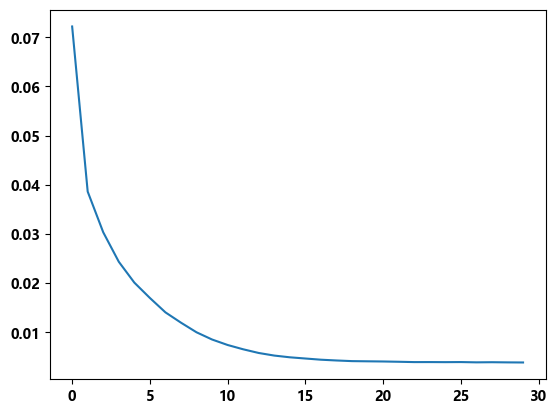

In [36]:
gru_model = get_gru_model(time_step)
history = gru_model.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
plt.plot(history.history['loss'])
# plt.title('GRU 模型损失函数图像')
plt.show()

In [37]:
# 绘制预测结果
def get_pred_plt(real_x, real_y, y_pred, time_x, time_y, title='Predict', xlabel='Data', ylabel='Package'):
    plt.figure()
    plt.plot(time_y, y_pred, linestyle='--', label = '预测结果')
    plt.plot(time_y, real_y, linestyle='-', label = '真实结果')
    # plt.plot(time_x, real_x, color='g', label = 'Real_x')
    # plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(rotation=-15)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

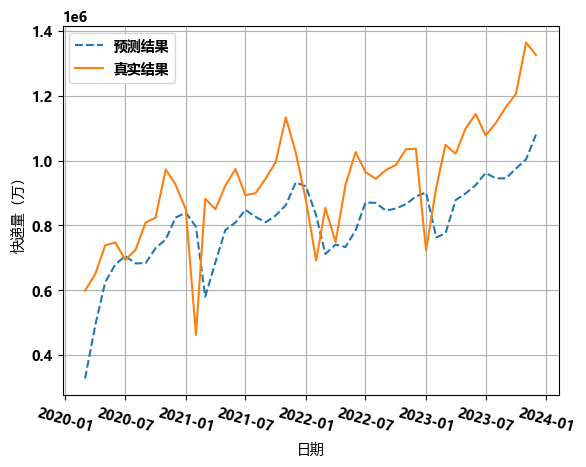

In [38]:
# 模型预测
gru_pred = gru_model.predict(test_x)
gru_pred = scaler.inverse_transform(gru_pred.reshape(-1,1))
gru_real_y = scaler.inverse_transform(test_y.reshape(-1,1))
gru_real_x = scaler.inverse_transform(test_x[:,0].reshape(-1,1))
get_pred_plt(gru_real_x, gru_real_y, gru_pred, time_x, time_y, title='GRU 模型预测结果对比图', xlabel='日期', ylabel='快递量（万）')


In [108]:
# 模型误差评估
gru_err_x = get_error(gru_real_x, gru_pred)
gru_err_y = get_error(gru_real_y, gru_pred)
err = pd.DataFrame((gru_err_x, gru_err_y), index=['gru_err_x', 'gru_err_y'], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])

In [109]:
# 对神经网络模型重复建模实验
# 获取预测结果
gru_preds = []
for i in range(10):
    model = get_gru_model(time_step)
    model.fit(train_x, train_y, epochs=30, batch_size=12, verbose=0)
    gru_pred = model.predict(test_x)
    gru_pred = scaler.inverse_transform(gru_pred.reshape(-1,1))
    gru_preds.append(gru_pred)
# 生成误差评价
gru_err_xs = []
for i in range(10):
    gru_err_x = get_error(gru_real_x, gru_preds[i])
    gru_err_xs.append(gru_err_x)
gru_errs_xs = pd.DataFrame(gru_err_xs, index=['gru_model_'+str(i) for i in range(1,11)], columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])
mean = gru_errs_xs.mean(axis=0)
mean = pd.DataFrame(mean).T
mean.index = ['Average']
gru_errs_xs = pd.concat([gru_errs_xs, mean], axis=0)


In [110]:
gru_errs_xs.to_csv('./basic/gru_errs_x.csv', index=True, header=True, encoding='utf-8')